# Part 1: Fraudulent Email Detection  

#### Context at Brevo -------------------------------------------

***  
*`ESP's (Email Service Providers) have a critical responsibility in preventing fraud and spam. This is because unchecked fraud and spam can severely damage an ESP's reputation, harming the deliverability of emails for all clients. Spam and fraudulent emails erode user trust in email as a communication channel, lowering engagement rates and making it harder for businesses to connect with their audiences legitimately. By taking proactive measures against fraud and spam, ESPs can protect their own business interests, maintain a healthy email ecosystem, and uphold their commitment to serving clients ethically.`*  
***

#### Model Building ----------------------------------------------------------------

* **Task:** Build a Machine Learning or Deep Learning model to predict whether an email is fraudulent or not based on the provided data in the train.csv file.

### 1. Load Necessary Libraries and Dataset

* **We need to install some libraries before importing them**

In [1]:
!pip install missingno xgboost catboost nltk lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 12.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 119.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 7.4 MB/s eta 0:00:00


In [2]:
# for data manipulation
import pandas as pd
import numpy as np

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as  msno
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import nbformat
from wordcloud import WordCloud

# nltk for text preprocessing
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Preprocessing (sklearn)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
import xgboost as xgb
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Scoring
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Styling
plt.style.use('ggplot')



2024-03-10 20:14:19.858981: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-10 20:14:25.412224: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-03-10 20:14:25.412993: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

* **Load the data**

In [3]:
df = pd.read_csv("train.csv")
df.head()

subject  \
0                                                123   
1  Re: [opensuse] Mounting an vmware virtual disk...   
2                             winning notification :   
3  fw : ipp update : analysis of power market con...   
4                      Offer variety replica watches   

                                                body  label  
0  I got something to tell you! Fist-rate experie...      1  
1  On Monday 18 February 2008 06:39:43 pm Jonatha...      0  
2  universal trust worldwide lottery .\n138 edwar...      1  
3  indicatesselling was overdone ; focus on cpn a...      0  
4  \nLooking for qualitative watches? Go to Repli...      1

In [4]:
df.shape

(63437, 3)

As we can see we have 63437 observations and 3 columns (**`subject`**, **`body`**, and **`label`**)

* **checking the missing values in each columns**

<Axes: >

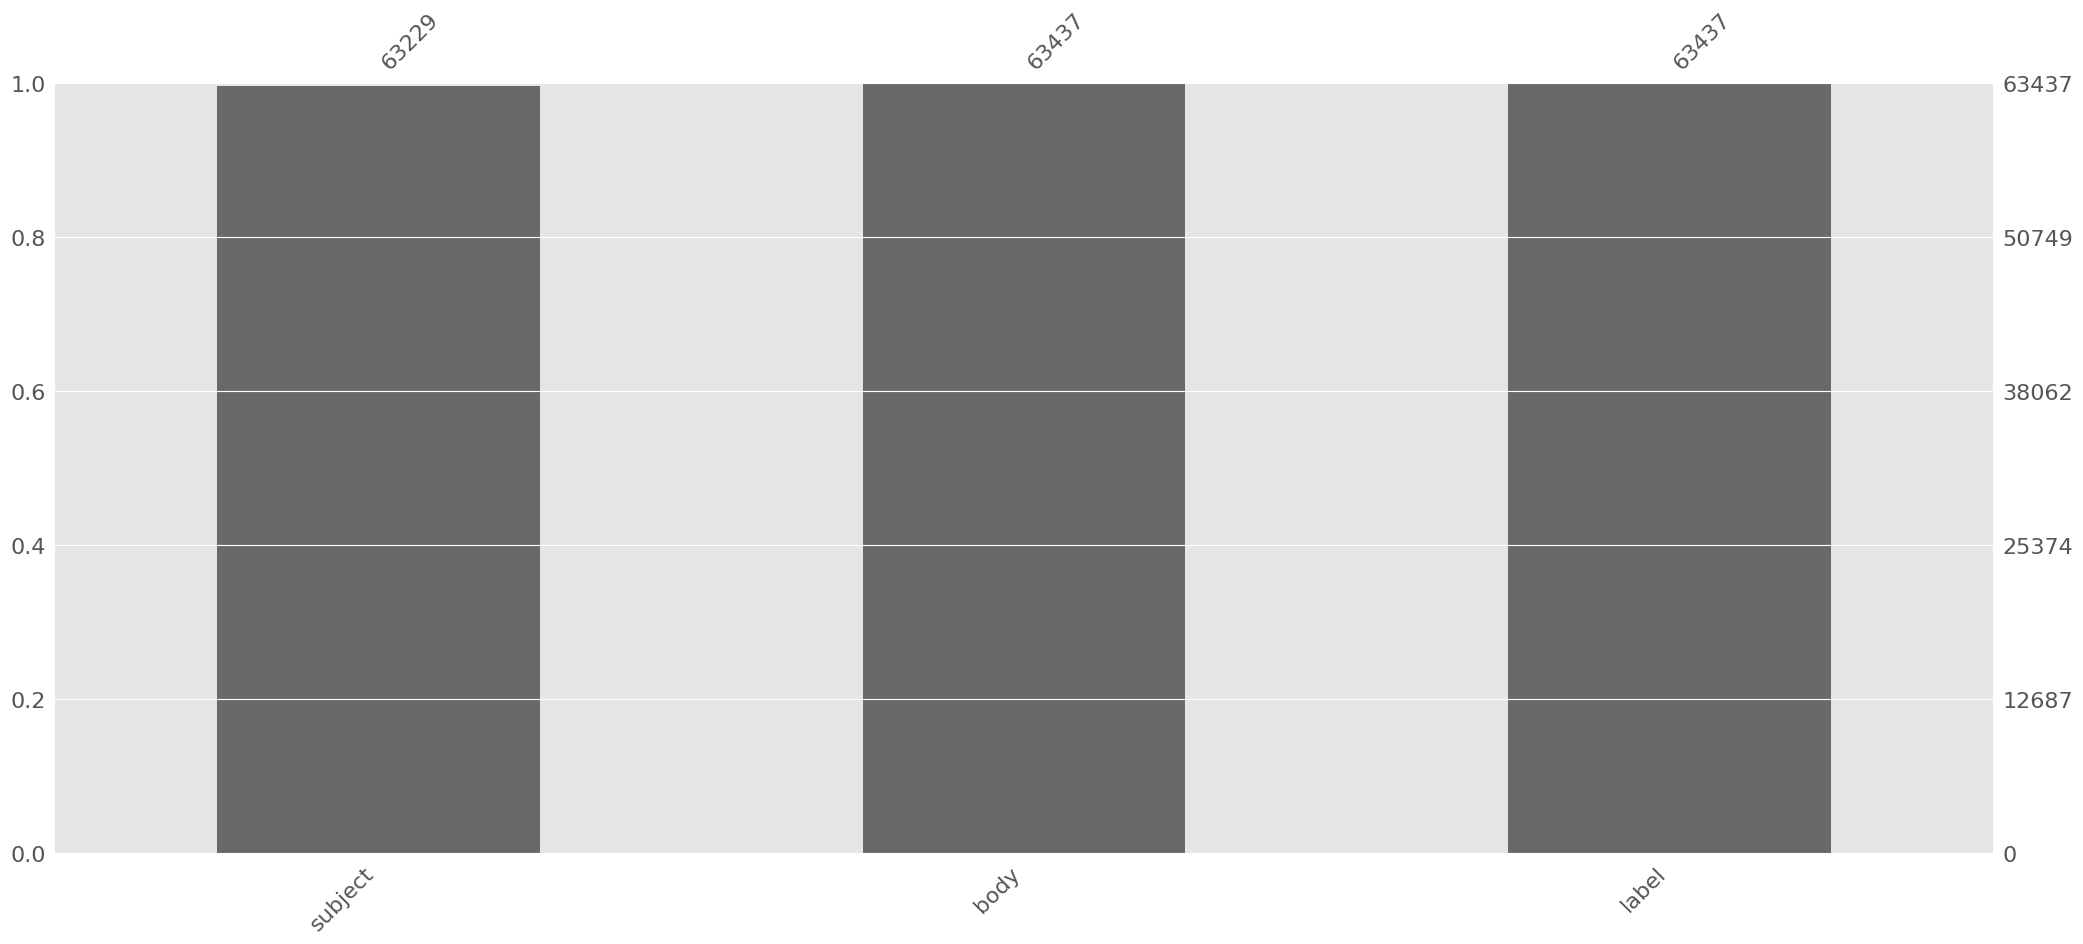

In [5]:
msno.bar(df)

This bar chart gives us an idea about how many missing values are there in each column. In our example, we have 208 missing values for the column subject.
That's mean some email doesn't have a subject.

I suggest combining the two columns `subject` et `body` to one columns `message`.  
Because combining the subject and body of an email into a single texte feature can provide a more comprehensive representation of the content of the email, which can potentially improve the performance of the predictive model.  

* **Richer Information:** The subject line typically provides a brief summary or hint about the content of the email, while the body contains the main content, including details, context, and potentially important keywords. By combining both the subject and body, you capture a broader range of information, which can help the model make better predictions.  

* **Contextual Understanding:** Some emails might contain crucial information in both the subject and body, and understanding the relationship between them could be valuable for classification. For instance, a subject line might indicate a topic, and the body elaborates on it or provides additional details. Combining them allows the model to learn from this context.  

* **Enhanced Feature Representation:** Combining subject and body text into a single feature simplifies the feature representation process. Instead of dealing with two separate text fields, you have one consolidated feature, making it easier to apply text processing techniques like tokenization, TF-IDF, or word embeddings.  

* **Improved Model Performance:** In many cases, models trained on richer, more comprehensive features tend to perform better than those trained on limited or fragmented features. Combining subject and body text can potentially lead to a more informative feature representation, thus improving the model's predictive performance.  

In [6]:
# Combine the columns and fill missing values with empty string
df['message'] = df['subject'].fillna('') + ' ' + df['body']

In [7]:
# Drop the original 'subject' and 'body' columns
df.drop(columns=['subject', 'body'], inplace=True)

In [8]:
df.head()

label                                            message
0      1  123 I got something to tell you! Fist-rate exp...
1      0  Re: [opensuse] Mounting an vmware virtual disk...
2      1  winning notification : universal trust worldwi...
3      0  fw : ipp update : analysis of power market con...
4      1  Offer variety replica watches \nLooking for qu...

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63437 entries, 0 to 63436
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    63437 non-null  int64 
 1   message  63437 non-null  object
dtypes: int64(1), object(1)
memory usage: 991.3+ KB


### Exploratory Data Analysis

* **Adding a category column to facilitate our EDA**

In [10]:
def map_label_to_category(label):
    if label == 1:
        return 'spam'
    elif label == 0:
        return 'ham'
    else:
        return'unknown'

df['category'] = df['label'].apply(map_label_to_category)

df.head()

label                                            message category
0      1  123 I got something to tell you! Fist-rate exp...     spam
1      0  Re: [opensuse] Mounting an vmware virtual disk...      ham
2      1  winning notification : universal trust worldwi...     spam
3      0  fw : ipp update : analysis of power market con...      ham
4      1  Offer variety replica watches \nLooking for qu...     spam

* **Distribution of each category**

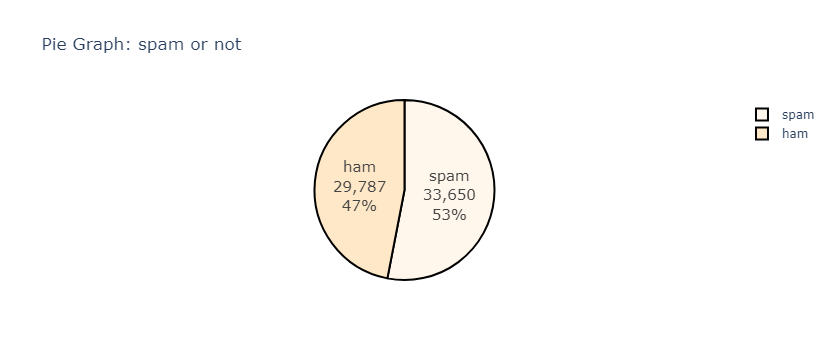

In [11]:
category_ct = df['category'].value_counts()

fig = px.pie(values=category_ct.values,
             names=category_ct.index,
             color_discrete_sequence=px.colors.sequential.OrRd,
             title= 'Pie Graph: spam or not')
fig.update_traces(hoverinfo='label+percent', textinfo='label+value+percent', textfont_size=15,
                  marker=dict(line=dict(color='#000000', width=2)))

fig.show()

Spam category accounts for 53% with 33650 values in the dataset.

* **Length distribution of spam & ham meesage**

In [12]:
categories = pd.get_dummies(df["category"])
spam_or_not = pd.concat([df, categories], axis=1)
spam_or_not.drop(['label', 'category'],axis=1,inplace=True)

df["length"] = df["message"].apply(len)

ham = df.loc[np.where(spam_or_not['ham'] == 1)].reset_index()
spam = df.loc[np.where(spam_or_not['ham'] == 0)].reset_index()

ham.drop('index',axis=1,inplace=True)
spam.drop('index',axis=1,inplace=True)

#### Ham & Spam Message Analysis

Here, we'll explore unigrams of ham & spam messages, using **barplot** and **wordcloud**.


Defined 8 functions, each are:
* **get_all_str():** to get all of strings from dataframe column.
* **get_str():** get string from list
* **get_word():** to get words from text, using RegexpTokenizer
* **stopword_list():** to add stopwords to nltp stopword list
* **remove_stopword():** to remove stopwords from list
* **Freq_df():** to get dataframe from cleanwordlist
* **lemmatization():** to lemmatize words  

and also visualization function:

* **Word_Cloud():** plot word cloud of words

By applying these preprocessing techniques on our data, we create a cleaner and more manageable text dataset for further analysis and modeling.

In [14]:
# function to get all of strings from dataframe column, and used lower function here.
def get_all_str(df):
    sentence = ''
    for i in range(len(df)):
        sentence += df['message'][i]
    sentence = sentence.lower()
    return sentence

def get_str(lst):
    sentence = ''
    for char in lst:
        sentence += char+' '
    sentence = sentence.lower()
    return sentence

# function to get words from text(string). used RegexpTokenizer
def get_word(text):
    result = nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())
#     result = result.lower()
#     result = nltk.word_tokenize(text)
    return result

# function to add stopwords to nltp stopword list.
def stopword_list(stop):
    lst = stopwords.words('english')
    for stopword in stop:
        lst.append(stopword)
    return lst

# function to remove stopwords from list.
def remove_stopword(stopwords, lst):
    stoplist = stopword_list(stopwords)
    txt = ''
    for idx in range(len(lst)):
        txt += lst[idx]
        txt += '\n'
    cleanwordlist = [word for word in txt.split() if word not in stoplist]
    return cleanwordlist

# function to get dataframe from cleanwordlist.
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    df_freq = df_freq.reset_index()
    return df_freq

# function to lemmatize words
def lemmatization(words):
    lemm = WordNetLemmatizer()
    tokens = [lemm.lemmatize(word) for word in words]
    return tokens

* **Visualization functions below:**

In [15]:
# function to plot word cloud of words
def Word_Cloud(data, color_background, colormap, title):
    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=100,
               colormap= colormap,
               max_font_size=140,
               min_font_size = 2,
               random_state=8888,
               background_color=color_background).generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

####  Term frequency by ham message

In [16]:
ham.tail(3)

label                                            message category  \
29784      0  re : fw : opportunities gerry ,\ni may have un...      ham   
29785      0  global markets monitor - 19 jan 01 please find...      ham   
29786      0  Re: [python-win32] Apache & mod_python & win32...      ham   

       length  
29784     872  
29785     131  
29786    3596

* **remove stopwords**

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
string = get_all_str(ham)
words = get_word(string)
removed = remove_stopword('1',words)
# show 10 words for example
print(removed[:10])

['opensuse', 'mounting', 'vmware', 'virtual', 'disk', 'linux', 'monday', '18', 'february', '2008']


We can see the result of last 10 words

* **bar plot of ham message**

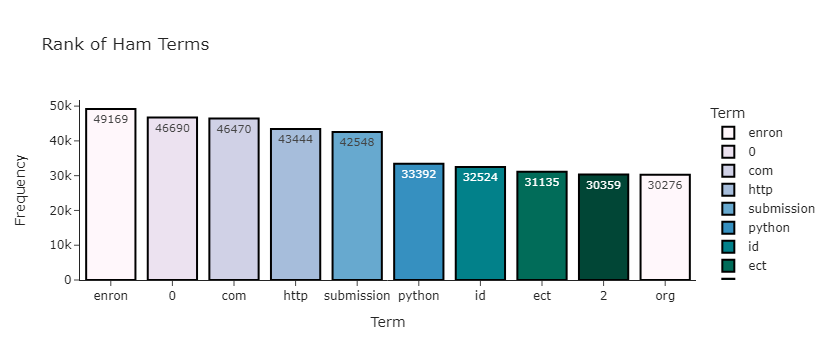

In [19]:
freq_df = Freq_df(removed)
top_10 = freq_df[:10]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency', color='Term',
             color_discrete_sequence=px.colors.sequential.PuBuGn,
             title = 'Rank of Ham Terms',
             template = "simple_white"
              )

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.update_traces(textposition='inside',
                  textfont_size=11)
fig.show()

'enron', 'com', '0' ranked top 3 words in ham category.

* **Word cloud of ham message**

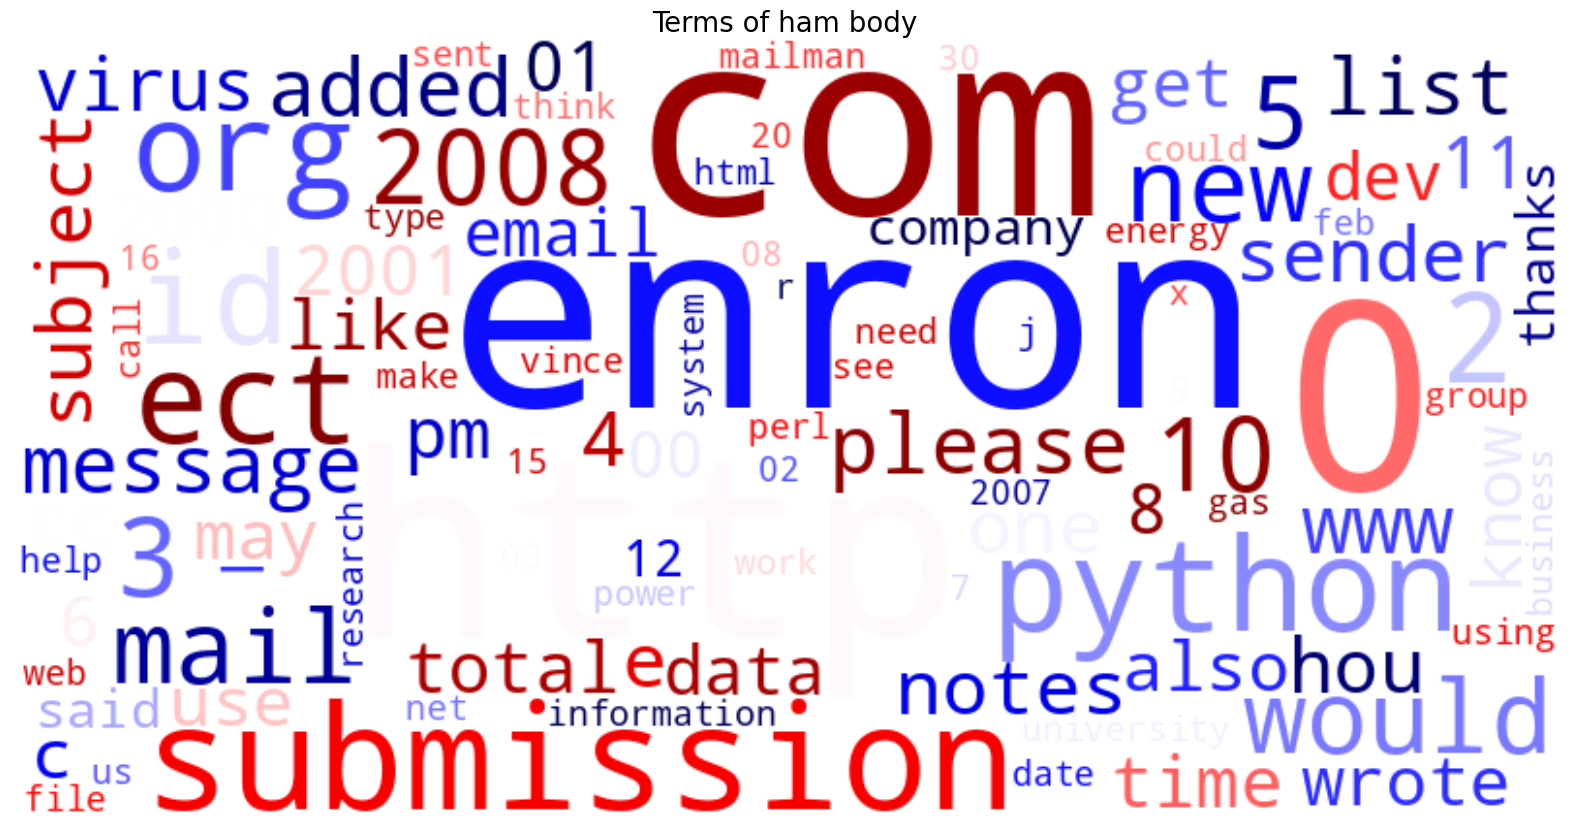

In [20]:
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

ham_wordcloud = Word_Cloud(data ,'white', 'seismic', 'Terms of ham body')

Above is a word cloud of ham body. As we expected, we have the most frequent words which are highlighted: 
* 'enro', 'company', 'energy': This likely indicates that the dataset includes messages related to or originating from Enron Corporation. In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud.  
* 'O': This could be a placeholder or formatting artifact. It might be worthwhile to investigate why "O" appears frequently in the messages. It could represent some common formatting or placeholder text.  
* 'com', 'http', 'www', 'org': This likely indicates that many messages contain references or links to websites or online ressources.
* 'submission': This word suggests that there may be frequent mentions of submissions within the messages. This could relate to various types of submissions such as documents, forms, or requests.
* 'python': The presence of "python" indicates that Python programming-related content is present in the dataset. This could include discussions, code snippets, or references to Python programming language.

Now let's explore spam body in the next section.

#### Term frequency by spam messages

In [21]:
string = get_all_str(spam)
words = get_word(string)
removed = remove_stopword('1',words)

* **bar plot of spam message**

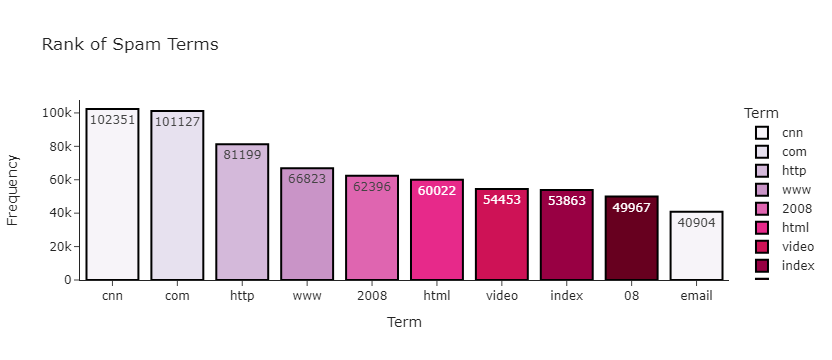

In [22]:
# plt.figure(figsize=(20,5))
# sns.barplot(data = freq_df[:10],
#             x = 'Term', y = 'Frequency')
freq_df = Freq_df(removed)
top_10 = freq_df[:10]

fig = px.bar(top_10, x = 'Term', y = 'Frequency',text = 'Frequency',
             color_discrete_sequence=px.colors.sequential.PuRd,
             title = 'Rank of Spam Terms',
             template = "simple_white",
             color='Term')

for idx in range(len(top_10)):
    fig.data[idx].marker.line.width = 2
    fig.data[idx].marker.line.color = "black"

fig.show()

Obviously, 'cnn', 'com' and 'http' ranked top 3 frequency terms in spam messages.

* **Word cloud of spam body**

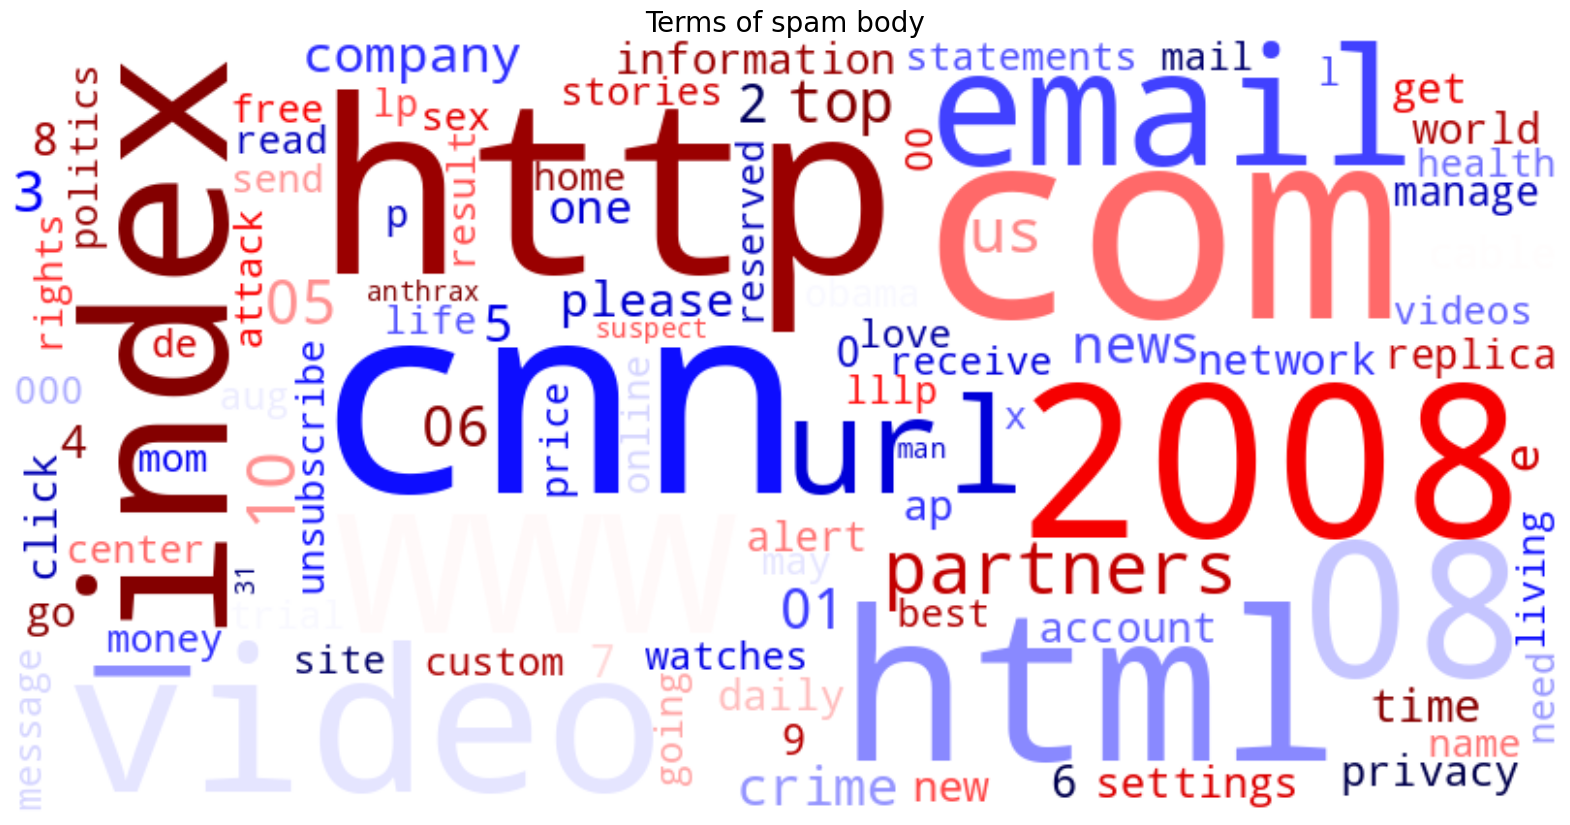

In [23]:
data = dict(zip(freq_df['Term'].tolist(), freq_df['Frequency'].tolist()))
data = freq_df.set_index('Term').to_dict()['Frequency']

spam_wordcloud = Word_Cloud(data, 'white','seismic', 'Terms of spam body')

It is obvious that word cloud of spam category is a little different from ham category.
* 'cnn': The presence of "cnn" suggests that the spam emails may contain references to the Cable News Network (CNN), which could be used to make the emails appear legitimate or to attract attention.  
* 'com', 'http', 'www', 'html', 'index': often appear together in spam emails, indicating references to websites or online resources with ".com" domains. These links, embedded within HTML formatting, could lead recipients to phishing sites, malware downloads, or other fraudulent activities. Additionally, terms like "index" may be used in URLs to mimic real website structures and make the emails appear more legitimate.

### Text preprocessing for spam email detection  

* **function to get words from sentence, and lemmatize it with removing stopwords**

The `preprocess` function takes a sentence as input, tokenizes it into words, lemmatizes those words, removes any stopwords, and returns the preprocessed list of words

In [24]:
def preprocess(sentence):
    words = get_word(sentence)
    words_ltz = lemmatization(words)
    removed = remove_stopword('1',words_ltz)
    return removed

Remove the category column

In [25]:
df.drop(columns=['category'], inplace=True)

In [26]:
df.head()

label                                            message  length
0      1  123 I got something to tell you! Fist-rate exp...     500
1      0  Re: [opensuse] Mounting an vmware virtual disk...     477
2      1  winning notification : universal trust worldwi...    2379
3      0  fw : ipp update : analysis of power market con...    3379
4      1  Offer variety replica watches \nLooking for qu...     221

####  CountVectorizer  

* **CountVectorizer is used to convert text documents to a vector of term counts (a matrix of token counts).**

In [27]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...


True

In [28]:
vector = CountVectorizer(analyzer = preprocess)
X = vector.fit(df['message'])
X_transform = X.transform(df['message'])

#### tf-idf transformer  

* **Transform a count matrix to a normalized tf-idf representation.**  
We use the `TfidfVectorizer` from the scikit-learn library to convert the text data into a numerical format suitable for machine learning.

In [29]:
tfidf_transformer = TfidfTransformer().fit(X_transform)
X = tfidf_transformer.transform(X_transform)

#### Train-test split  

* **Split dataset into train set and test set, by ratio of 0.3**  
The dataset is split into training and testing sets using the `train_test_split` function. This division allows us to evaluate the model's performance on unseen data.

In [30]:
train_X, test_X, train_y, test_y = train_test_split(X, df['label'], test_size=0.30, random_state = 42)

### Text Classification

We will use 4 classification model:  
* **`RandomForestClassifier`**: Random Forest is a supervised machine learning algorithm which is based on ensemble learning. It is one of the most flexible and easy to use algorithm. It creates decision trees on the given data samples, gets prediction from each tree and selects the best solution by means of voting. It is also a pretty good indicator of feature importance.
Random forest algorithm combines multiple decision-trees, resulting in a forest of trees, hence the name Random Forest. In the random forest classifier, the higher the number of trees in the forest results in higher accuracy.  

* **`LightGBMClassifier`**:  LGBMClassifier stands for Light Gradient Boosting Machine Classifier. It uses decision tree algorithms for ranking, classification, and other machine-learning tasks.  It is designed to be distributed and efficient with the following advantages:
*Faster training speed and higher efficiency,
Lower memory usage,
Better accuracy,
Support of parallel and GPU learning,
Capable of handling large-scale data.*


 * **`XGBClassifier`**: The XGBoost stands for eXtreme Gradient Boosting, which is a boosting algorithm based on gradient boosted decision trees algorithm. XGBoost applies a better regularization technique to reduce overfitting, and it is one of the differences from the gradient boosting.  
 * **`CatBoostClassifier`**: CatBoost is a high-performance open source library for gradient boosting on decision trees that specializes in handling categorical variables.It builds an ensemble of decision trees sequentially, with each subsequent tree aiming to correct the errors made by the previous ones. One of the standout features of CatBoost is its ability to handle categorical features automatically. It internally converts categorical variables into numerical values using various statistical methods, eliminating the need for explicit preprocessing of categorical features.

* **Define classifiers**  
Here we defined non-tuned classifier first:

In [31]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(train_X, train_y)

RandomForestClassifier(random_state=42)

In [32]:
lgbm = LGBMClassifier(boosting_type='gbdt', objective='binary', random_state=42)
lgbm.fit(train_X, train_y)

[LightGBM] [Info] Number of positive: 23503, number of negative: 20902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.695182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 759909
[LightGBM] [Info] Number of data points in the train set: 44405, number of used features: 15348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529287 -> initscore=0.117283
[LightGBM] [Info] Start training from score 0.117283


LGBMClassifier(objective='binary', random_state=42)

In [33]:
xgbr = xgb.XGBClassifier(objective='binary:hinge', random_state=42)
xgbr.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='binary:hinge', ...)

In [35]:
catboost = CatBoostClassifier(random_seed=42, logging_level='Silent')
catboost.fit(train_X, train_y)

In [36]:
classifiers = []
#classifiers.append(svc)
classifiers.append(rfc)
classifiers.append(xgbr)
classifiers.append(lgbm)
classifiers.append(catboost)

model_name = ['Random Forest', 'XGBClassifier', 'LGBMClassifier', 'CatBoostClassifier']

#### Compare Evaluation Matrix

* **Get matrix score of each classifiers**

In [37]:
accuracy_list = []
auc_list=[]
recall_list = []
f1_list = []

for classifier in classifiers :
    y_pred=classifier.predict(test_X)
    
    accuracy_list.append(accuracy_score(test_y,y_pred))
    auc_list.append(roc_auc_score(test_y, y_pred))
    recall_list.append(recall_score(test_y, y_pred))
    f1_list.append(f1_score(test_y, y_pred))

* **And we define plot function used for visualize scores and accuracy**

In [38]:
def plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list, title):

    fig = go.Figure(data=[
        go.Bar(name='Accuracy', x=model_name, y=np.round(accuracy_list,3),  text=np.round(accuracy_list,3),   marker_color='#97bad9'),
        go.Bar(name='AUC',      x=model_name, y=np.round(auc_list,3),       text=np.round(auc_list,3),        marker_color= '#bcd6ef'),
        go.Bar(name='Recall',   x=model_name, y=np.round(recall_list,3),    text=np.round(recall_list,3),     marker_color='#ebcad9'),
        go.Bar(name='F1',       x=model_name, y=np.round(f1_list,3),        text=np.round(f1_list,3),         marker_color='#d5a6bd')
    ])

    fig.update_layout(template = 'simple_white', title = title)
    fig.update_layout(xaxis_title="Models", yaxis_title="Score", font = dict(size=17, family = 'Franklin Gothic'))
    fig.update_layout(yaxis_range=[0.7,1])

    fig.show()

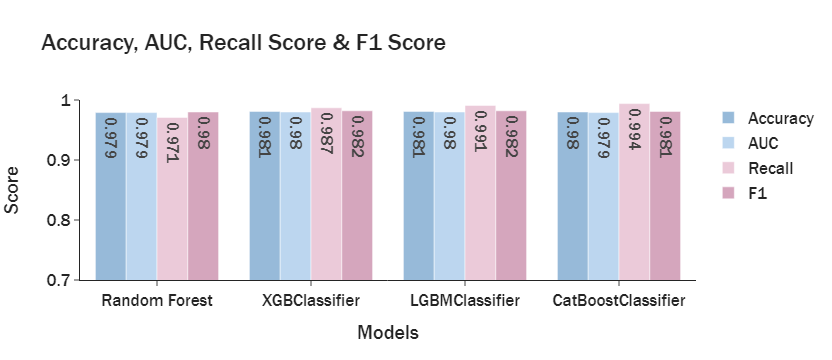

In [39]:
plot_model_score(model_name, accuracy_list, auc_list, recall_list, f1_list,
                 'Accuracy, AUC, Recall Score & F1 Score')

Here we can see that **LGBMClassifier**  and **XGBClassifier** got the highest ***AUC score***, following by the **CatBoostClassifier** and the **RandForest**.

Consider that models may exist **overfitting**, let's see mean values of cross validation score.

#### Cross Validation  

For Cross validation, we will used `StratifiedKFold`, which returns stratified folds.  
Stratified kfold cross validation is an extension of regular kfold cross validation but specifically for classification problems where rather than the splits being completely random, the ratio between the target classes is the same in each fold as it is in the full dataset.  

I have kept n_splits to be 2, dividing our dataset for 2 times. Also, the shuffling is kept to be True.

In [40]:
# set random_state
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cv_accuracy_results = []
cv_auc_results = []
cv_recall_results = []
cv_f1_results = []

for classifier in classifiers:
    accuracy_scores = cross_val_score(classifier, train_X, y=train_y, scoring="accuracy", cv=kfold)
    cv_accuracy_results.append(accuracy_scores)

    auc_scores = cross_val_score(classifier, train_X, y=train_y, scoring='roc_auc', cv=kfold)
    cv_auc_results.append(auc_scores)

    recall_scores = cross_val_score(classifier, train_X, y=train_y, scoring='recall', cv=kfold)
    cv_recall_results.append(recall_scores)

    f1_scores = cross_val_score(classifier, train_X, y=train_y, scoring='f1', cv=kfold)
    cv_f1_results.append(f1_scores)

cv_accuracy_means = [np.mean(scores) for scores in cv_accuracy_results]
cv_auc_means = [np.mean(scores) for scores in cv_auc_results]
cv_recall_means = [np.mean(scores) for scores in cv_recall_results]
cv_f1_means = [np.mean(scores) for scores in cv_f1_results]


[LightGBM] [Info] Number of positive: 11751, number of negative: 10451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.778500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440102
[LightGBM] [Info] Number of data points in the train set: 22202, number of used features: 9750
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529277 -> initscore=0.117241
[LightGBM] [Info] Start training from score 0.117241
[LightGBM] [Info] Number of positive: 11752, number of negative: 10451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.743857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 433473
[LightGBM] [Info] Number of data points in the train set: 22203, number of used features: 9596
[LightGBM] [

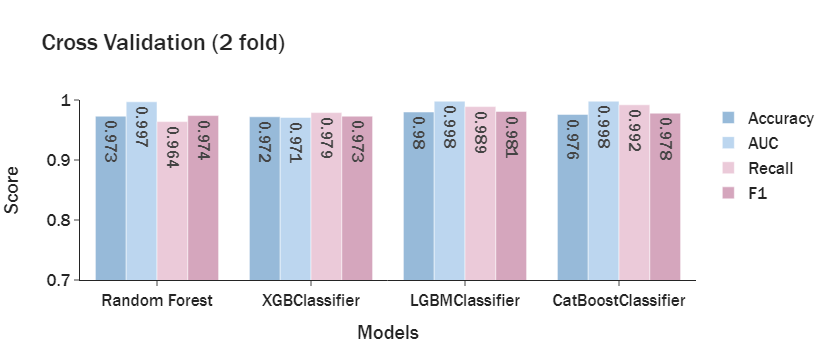

In [41]:
plot_model_score(
    model_name,
    cv_accuracy_means,
    cv_auc_means,
    cv_recall_means,
    cv_f1_means,
    'Cross Validation (2 fold)')

It can be easily seen that **LGBMClassifier**, **CatBoostClassifier** and **RandomForest** got overall high score of each matrix ***AUC score***.

Thus, i decided these three models to build an ensemble model using voting classifier.

### Voting classifier  

As mentioned above, i selected **Random Forest**, **LGBMClassifier** and **CatBoostClassifier** to build a voting classifier.  
The voting classifier is an ensemble learning method that combines several base models to produce the final optimum solution. We create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.
The algorithm aggregates the results of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting.
Since voting relies on the performance of many models, they will not be affected by large errors or misclassifications from one model. In other words poor performance from one model can be offset by a strong performance from other models.

In [ ]:
votingC = VotingClassifier(estimators=[
                                      ('light gbm', lgbm),
                                      ('Random Forest', rfc),
                                      ('Cat boost',catboost)],
                            voting='soft')

votingC = votingC.fit(train_X, train_y)

v_accuracy = cross_val_score(votingC, train_X, y = train_y, scoring = "accuracy", cv = kfold)
v_auc = cross_val_score(votingC, train_X, y = train_y, scoring = "roc_auc", cv = kfold)
v_recall = cross_val_score(votingC, train_X, y = train_y, scoring = "recall", cv = kfold)
v_f1 = cross_val_score(votingC, train_X, y = train_y, scoring = "f1", cv = kfold)

votingC_accuracy_mean = v_accuracy.mean()
votingC_auc_mean = v_auc.mean()
votingC_recall_mean = v_auc.mean()
votingC_f1_mean = v_auc.mean()

model_name.append('Voting Classifier')
cv_accuracy_means.append(votingC_accuracy_mean)
cv_auc_means.append(votingC_auc_mean)
cv_recall_means.append(votingC_recall_mean),
cv_f1_means.append(votingC_f1_mean)

[LightGBM] [Info] Number of positive: 23503, number of negative: 20902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 2.296985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 759909
[LightGBM] [Info] Number of data points in the train set: 44405, number of used features: 15348
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.529287 -> initscore=0.117283
[LightGBM] [Info] Start training from score 0.117283
[LightGBM] [Info] Number of positive: 11751, number of negative: 10451
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.826362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 440102
[LightGBM] [Info] Number of data points in the train set: 22202, number of used features: 9750
[LightGBM] 

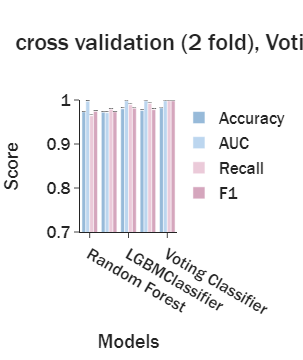

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means,
                 'cross validation (2 fold), Voting Classifier Added')

As we expected, the **`Voting Classifier`** performed the best for all metrics.

#### Voting Classifier: Model Evaluation

In [53]:
voting_y_pred = votingC.predict(test_X)

voting_y_pred

array([0, 0, 0, ..., 1, 1, 0])

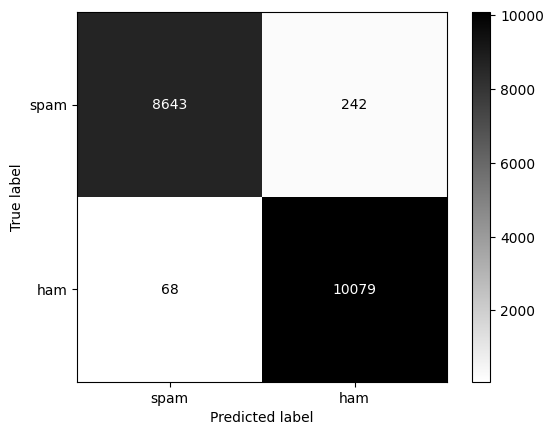

In [54]:
plt.style.use('default')
cm = confusion_matrix(test_y, voting_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['spam','ham'])
disp.plot(cmap='binary', values_format=".0f")

plt.show()

From the above confusion matrix, we get the four numbers:  
The first row of this matrix considers *spam message*(**the negative class**): 8643 of them were correctly classified as *spam* (they are called **True negative**), while the remaining 242 were wrongly classify as *ham message* (**false positive**).    
The second row considers the *ham message* (**the positive class**):68 were wrongly classified as *spam message* (**false negative**), while the remaining 10079 were correctly classified as *ham message* (**True positive**). 

* **Saving our trained model as a pickle file**

In [55]:
import joblib
# Save trained model to a pickle file
joblib.dump(votingC, 'trained_model.pkl')

['trained_model.pkl']

## Making Predictions on the real test data

* **Loading the Test data**

In [56]:
test_data = pd.read_csv('test.csv')
copy_test_data = test_data.copy()

In [57]:
copy_test_data.head()

subject  \
0  phone service 2968 zuyw 7 - 202 ztvwo 499 - 20   
1                               from ben momodu .   
2                        Interesting cd Liv Tyler   
3      Re: [opensuse] 3.5 GB of RAM, Rest Missing   
4                     Christmas Replica Watches     

                                                body  
0  hi :\nhave\nyou been paying too much for your ...  
1  from ben momodu . union bank of nigeria plc 36...  
2  #AjDvdBClara Morgane Full photo.\n\n#ZMrmjAThe...  
3  Randall R Schulz wrote:\n> On Wednesday 20 Feb...  
4  \nTherefore it is very important to chose the ...

* **Prepocess the Test data**

In [58]:
# Combine the 'subject' and 'body' columns
copy_test_data['message'] = copy_test_data['subject'].fillna('') + ' ' + copy_test_data['body']

In [59]:
# Drop the original 'subject' and 'body' columns
copy_test_data.drop(columns=['subject', 'body'], inplace=True)

In [60]:
# Preprocess the test data
X_test = vector.transform(copy_test_data['message'])  # Use the same CountVectorizer as in training
X_test = tfidf_transformer.transform(X_test)  # Use the same TfidfTransformer as in training


* **Load trained model from pickle file**

In [61]:
spam_detection_model = joblib.load('trained_model.pkl')

* **Make predictions on test data**

In [62]:
test_predictions = spam_detection_model.predict(X_test)

* **Add predictions to test data**

In [63]:
test_data['prediction'] = test_predictions

* **Save predictions to a new CSV file**

In [64]:
test_data.to_csv('test_with_predictions.csv', index=False)

In [66]:
test_with = pd.read_csv('test_with_predictions.csv')
test_with.head()

subject  \
0  phone service 2968 zuyw 7 - 202 ztvwo 499 - 20   
1                               from ben momodu .   
2                        Interesting cd Liv Tyler   
3      Re: [opensuse] 3.5 GB of RAM, Rest Missing   
4                     Christmas Replica Watches     

                                                body  prediction  
0  hi :\nhave\nyou been paying too much for your ...           1  
1  from ben momodu . union bank of nigeria plc 36...           1  
2  #AjDvdBClara Morgane Full photo.\n\n#ZMrmjAThe...           1  
3  Randall R Schulz wrote:\n> On Wednesday 20 Feb...           0  
4  \nTherefore it is very important to chose the ...           1

### Additional Deep Learning model: **LSTM**  

here, I wanted to apply a deep learning model with LSTM.  
But due to lack of resources,too much execution time which results in a crash of the notebook and a disconnection of the execution kernel, I was not able to obtain the results to compare with the previous models.

In [ ]:
X = df['message']
y = df['label']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
max_len = max(max(train_X.apply(len).values), max(test_X.apply(len).values))

def fit_tokenizer(text, oov_token):
  tokenizer = Tokenizer(oov_token=oov_token)
  tokenizer.fit_on_texts(text)
  return tokenizer

# for sequence, padding
def seq_padding(sentences, tokenizer, padding, truncating, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  pad_trunc_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen, truncating=padding)
  return pad_trunc_sequences

tokenizer = fit_tokenizer(train_X, "<OOV>")

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

train_X = seq_padding(train_X, tokenizer, 'post', 'post', max_len)
test_X = seq_padding(test_X, tokenizer, 'post', 'post', max_len)

def callback(MATRIX, PATIENCE):
  callbacks = [EarlyStopping(
                            monitor=MATRIX,
                            patience=PATIENCE,
                            restore_best_weights=True),
              ModelCheckpoint('model',
                            monitor=MATRIX,
                            save_best_only=True,
                            save_weights_only=True)]
  return callbacks

def LSTM_model(vocab_size, embedding_dim, maxlen):

  model=Sequential()

  model.add(Embedding(vocab_size+1, embedding_dim, input_length=maxlen))
  model.add(Bidirectional(LSTM(64, kernel_regularizer=keras.regularizers.l2(0.001))))

  tf.keras.layers.GlobalAveragePooling1D()

  model.add(Dense(6, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['Accuracy'])

  return model


model = LSTM_model(VOCAB_SIZE, 100, max_len)
model.summary()


In [ ]:
history = model.fit(train_X, train_y, epochs=8, batch_size=8, callbacks=callback('Accuracy', 2))

test_prediction_label = (model.predict(test_X) >= 0.5).astype("int32")
NN_accuracy = accuracy_score(test_y, test_prediction_label)
NN_AUC = roc_auc_score(test_y, test_prediction_label)
NN_recal = recall_score(test_y, test_prediction_label)
NN_f1 = f1_score(test_y, test_prediction_label)

print(NN_accuracy, NN_AUC, NN_recall, NN_f1)

In [ ]:
cv_accuracy_means.append(NN_accuracy)
cv_auc_means.append(NN_AUC)
cv_recall_means.append(NN_recall),
cv_f1_means.append(NN_f1)
model_name.append('NN')

In [ ]:
plot_model_score(model_name, cv_accuracy_means, cv_auc_means, cv_recall_means, cv_f1_means,
                 'cross validation (2 fold)')

In [ ]:
df